In [176]:
%matplotlib notebook 
# Import modules
import os
import math
import numpy as np
import matplotlib.pyplot
import re
#import pandas as pd
from scipy.stats import norm
from pyne import serpent
from pyne import nucname
import time
import multiprocessing as mp
import itertools

In [3]:
def read_keff(index):
    res_file = dir+prefix+str(index)+'_res.m'
    res = serpent.parse_res(res_file, write_py=False)
    return res['IMP_KEFF'][:,0]
    
def read_comp(index):
    dep_file = dir+prefix+str(index)+'_dep.m'
    dep = serpent.parse_dep(dep_file, write_py=False,make_mats=False)
    return dep['MAT_fuel_MDENS']
    
dir = '../sampler/'
prefix = 'tap_'
fnum_start = 0   # first file index
fnum_end = 999   # last file index
iso_list = ['U235', 'U236','U238', 'Pu239', 'Pu240', 'Xe135', 'I135']

ncpu = mp.cpu_count()
# res_d = serpent.parse_res(dir+prefix+str(0)+'_res.m', write_py=False)
dep_d = serpent.parse_dep(dir+prefix+str(0)+'_dep.m', write_py=False,make_mats=False)
days = dep_d['DAYS']
vol_fuel = dep_d['MAT_fuel_VOLUME'][0]
iso_names = dep_d['NAMES'][0].split()
#print(vol_fuel)
#print(iso_names)

In [ ]:
start_time = time.time()
with mp.Pool(processes = ncpu) as p:
    k_ds_list = p.map(read_keff, [idx for idx in range(0, fnum_end-fnum_start+1)])
#d = read_comp(0)
#print(vol_fuel*d[iso_names.index('U235'),:])
k_ds_array = np.array(k_ds_list)
elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

In [4]:
# np.savetxt('keff_1000_samples.gz', k_ds_array, fmt='%s')
# np.savez_compressed('./keff_1000_samples.npz', b=k_ds_array)
with np.load('./keff_1000_samples.npz', allow_pickle=True) as data:
    k_ds_array = data['b']

In [ ]:
start_time = time.time()
with mp.Pool(processes = ncpu) as p:
    depletion_ds = p.map(read_comp, [idx for idx in range(0, fnum_end-fnum_start+1)])
depletion = np.array(depletion_ds)
#print(vol_fuel*depletion[iso_names.index('U235'),:])
elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

In [5]:
#np.savez_compressed('depleted_mass_1000_samples.npz', a=depletion_ds)
with np.load('depleted_mass_1000_samples.npz', allow_pickle=True) as data:
    depletion = data['a']

In [6]:
k_eff = []
std_k = []
rel_err = []
nsamp, nt = k_ds_array.shape

for t in range(nt):
    k_eff.append(np.mean(k_ds_array[:,t]))
    std_k.append(1e+5*np.std(k_ds_array[:,t]))
    rel_err.append(100*np.std(k_ds_array[:,t])/np.mean(k_ds_array[:,t]))

print(len(k_eff))            
#print(std_k)
print(r"Keff at BOC %5.5f +- %5.1f pcm; Std/mean %5.3f %%" %(k_eff[0],std_k[0], rel_err[0]))
print(r"Keff at EOC %5.5f +- %5.1f pcm; Std/mean %5.3f %%" %(k_eff[-1],std_k[-1], rel_err[-1]))

31
Keff at BOC 1.03620 +-  34.0 pcm; Std/mean 0.033 %
Keff at EOC 0.74814 +-  28.2 pcm; Std/mean 0.038 %


In [157]:
mass = {}
mass_std = {}
mass_rel = {}
nsampl, isos_number, nt = np.shape(depletion)

print(nsampl, isos_number, nt)
for iso in iso_list:
    iso_idx = iso_names.index(iso)
    mass[iso] = []
    mass_std[iso] = []
    mass_rel[iso] = []
    for t in range(nt):
        mass[iso].append(1e-3*vol_fuel*np.mean(depletion[:,iso_idx,t]))
        mass_std[iso].append(1e-3*vol_fuel*np.std(depletion[:,iso_idx,t]))
        mass_rel[iso].append(100* np.std(depletion[:,iso_idx,t])/np.mean(depletion[:,iso_idx,t]))

#print(mass)            
#print(mass_std)
#print(mass_rel)
print("U235 mass at BOC %7.3f +- %5.3f kg; Std/mean %5.4f %%" %(mass['U235'][1],mass_std['U235'][1], mass_rel['U235'][1]) )
print("U235 mass at EOC %7.3f +- %5.3f kg; Std/mean %5.4f %%" %(mass['U235'][-1],mass_std['U235'][-1], mass_rel['U235'][-1]) )
print("\nU238 mass at BOC %7.3f +- %5.3f kg; Std/mean %5.4f %%" %(mass['U238'][1],mass_std['U238'][1], mass_rel['U238'][1]) )
print("U238 mass at EOC %7.3f +- %5.3f kg; Std/mean %5.4f %%" %(mass['U238'][-1],mass_std['U238'][-1], mass_rel['U238'][-1]) )

1000 1622 31
U235 mass at BOC 6282.039 +- 0.038 kg; Std/mean 0.0006 %
U235 mass at EOC 782.374 +- 0.130 kg; Std/mean 0.0166 %

U238 mass at BOC 129500.687 +- 0.339 kg; Std/mean 0.0003 %
U238 mass at EOC 112158.933 +- 1.706 kg; Std/mean 0.0015 %


/home/andrei2/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


<IPython.core.display.Javascript object>


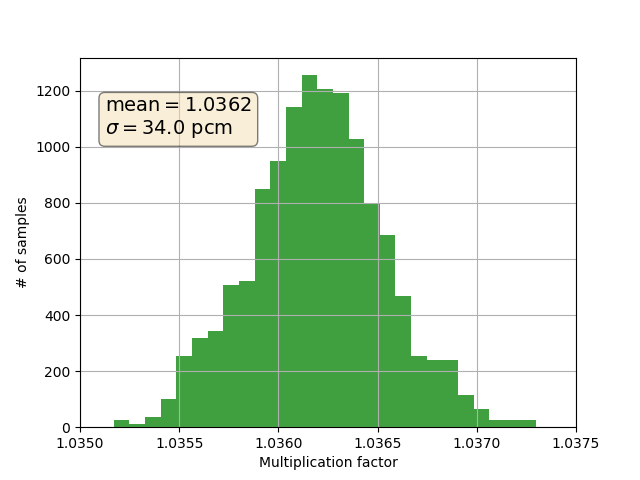

<IPython.core.display.Javascript object>


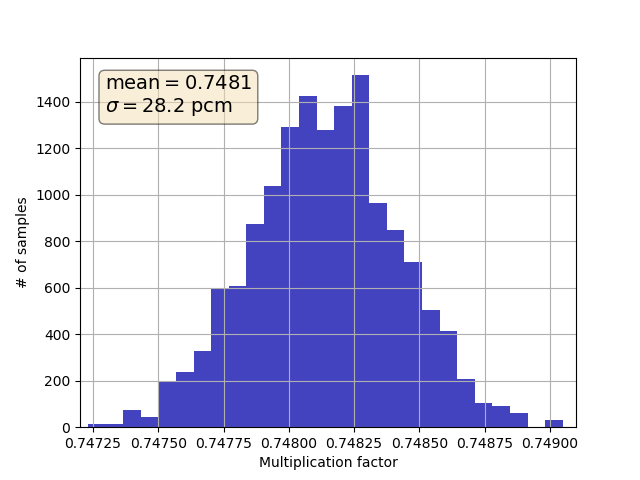

In [121]:
# Initialize figure
fig_1 = matplotlib.pyplot.figure(1)
ax = fig_1.add_subplot(111)
ax.grid(True)

textstr = '\n'.join((
    r'$\mathrm{mean}=%.4f$' % (k_eff[0]),
    r'$\sigma=%.1f$ pcm' % (std_k[0])))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

k_frac = k_ds_array[:,0]/float(len(k_ds_array[:,0]))
ax.hist(k_ds_array[:,0], bins=27, density=True, histtype='stepfilled', color='g',alpha=0.75)

ax.text(0.05, 0.89, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

#ax.legend(loc=0)
ax.set_xlabel(r'Multiplication factor')
ax.set_ylabel(r'# of samples')
#ax.set_title('Full-core TAP (Serpent): Infinite muliplication factor for BOL')
ax.set_xlim(1.035, 1.0375)
#fig_1.savefig('/home/andrei2/Desktop/git/publications/2020-rykhl-dissertation/dissertation/figures/uq_serpent_keff_boc_for_tap',bbox_inches='tight', dpi=700)
fig_1.show()

# Initialize figure
fig_2 = matplotlib.pyplot.figure(2)
ax = fig_2.add_subplot(111)
ax.grid(True)
ax.hist(k_ds_array[:,-1], bins=27, density=True, histtype='stepfilled', color='#0504aa',alpha=0.75)

textstr = '\n'.join((
    r'$\mathrm{mean}=%.4f$' % (k_eff[-1]),
    r'$\sigma=%.1f$ pcm' % (std_k[-1])))

ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

#ax.legend(loc=0)
ax.set_xlabel(r'Multiplication factor')
ax.set_ylabel(r'# of samples')
ax.set_xlim(0.7472, 0.7491)

#ax.set_title('Full-core TAP (Serpent): Infinite muliplication factor for EOL')
#fig_2.savefig('/home/andrei2/Desktop/git/publications/2020-rykhl-dissertation/dissertation/figures/uq_serpent_keff_eoc_for_tap.png',bbox_inches='tight', dpi=700)
fig_2.show()

<IPython.core.display.Javascript object>


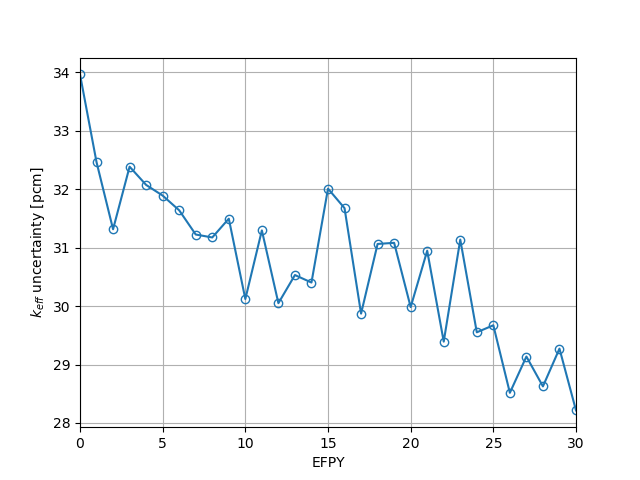

In [122]:
# Initialize figure
fig_keff_std = matplotlib.pyplot.figure(3)
ax = fig_keff_std.add_subplot(111)
ax.grid(True)
ax.plot(days/365.0, std_k, '-o', label='TAP', markerfacecolor="None")

#ax.legend(loc=0)
ax.set_ylabel(r'$k_{eff}$ uncertainty [pcm]')
ax.set_xlabel('EFPY')
ax.set_xlim(0, 30)
#ax.set_title('Multiplication factor uncertanty')
#fig_keff_std.savefig('/home/andrei2/Desktop/git/publications/2020-rykhl-dissertation/dissertation/figures/uq_serpent_keff_dynamics_for_tap.png', bbox_inches='tight', dpi=700)
fig_keff_std.show()

<IPython.core.display.Javascript object>


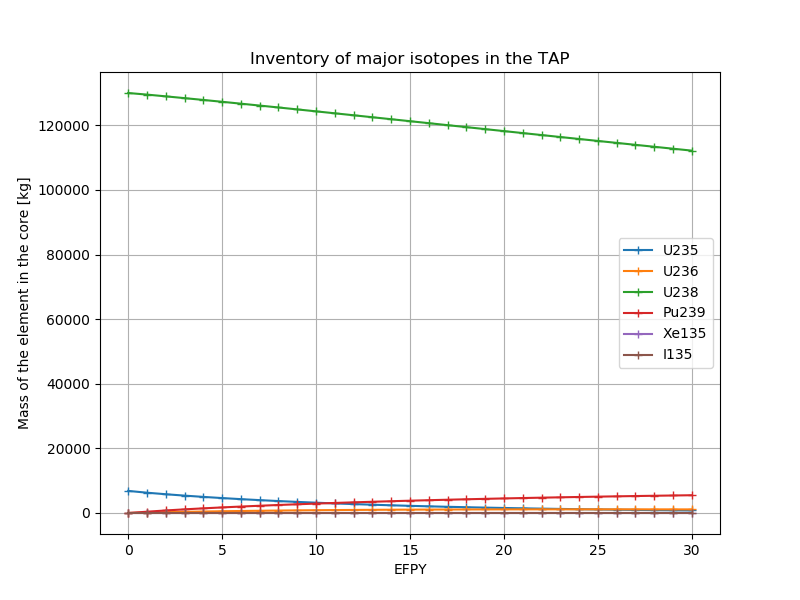

<IPython.core.display.Javascript object>


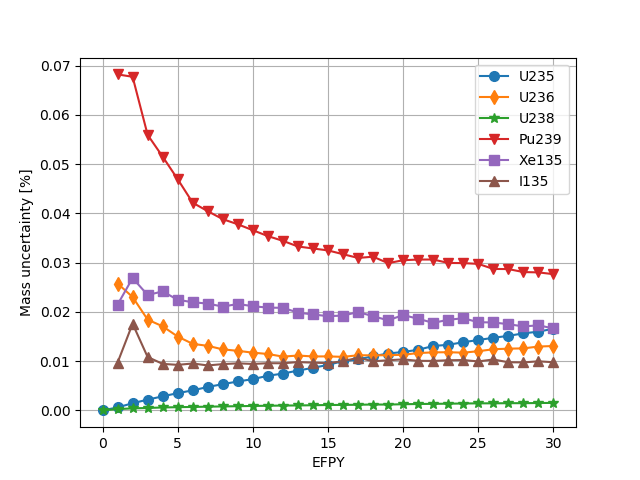

In [183]:
markers=itertools.cycle(('o','d','*','v','s','^','<','>','p','P','h','H','+','x','X','D','|','_'))
plot_list = ['U235', 'U236','U238', 'Pu239', 'Xe135', 'I135']
# Initialize figure
fig_mass = matplotlib.pyplot.figure(4, figsize=[8,6])
ax = fig_mass.add_subplot(111)
ax.grid(True)

for iso in plot_list:
    ax.plot(days/365.0, mass[iso], '+-', label=iso, markerfacecolor="None")

ax.legend(loc=0)
ax.set_ylabel(r'Mass of the element in the core [kg]')
ax.set_xlabel('EFPY')
ax.set_title('Inventory of major isotopes in the TAP')
fig_mass.show()
#fig_mass.savefig('keff_std_pwr_vs_tap.png', bbox_inches='tight', dpi=700)

# Initialize figure
fig_rel_error = matplotlib.pyplot.figure(5)
ax = fig_rel_error.add_subplot(111)
ax.grid(True)

for iso in plot_list:
    m=next(markers)
    ax.plot(days/365.0, mass_rel[iso], '-s', label=iso, markersize=7, marker=m)

ax.legend(loc=0)
ax.set_ylabel(r'Mass uncertainty [%]')
ax.set_xlabel('EFPY')
#ax.set_title('Uncertainty from Serpent in mass of major isotopes in the TAP')
fig_rel_error.show()
fig_rel_error.savefig('/home/andrei2/Desktop/git/publications/2020-rykhl-dissertation/dissertation/figures/uq_serpent_major_isotopes_mass_std.png', bbox_inches='tight', dpi=700)

<IPython.core.display.Javascript object>


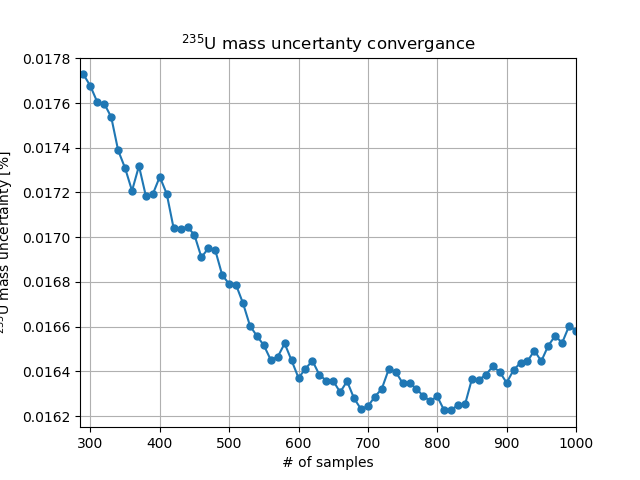

<IPython.core.display.Javascript object>


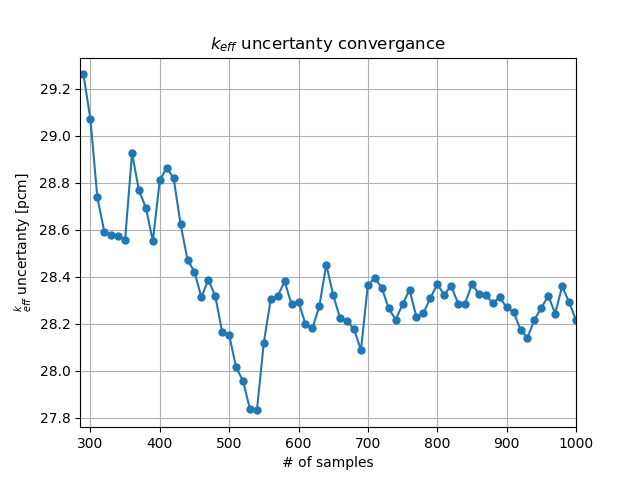

In [168]:
sample_number_list = np.arange(290, 1010, 10)
std_samp_conv_k = []
std_samp_conv = []

for num in sample_number_list:
    std_samp_conv_k.append(1e5*np.std(k_ds_array[:num,-1]))
    # mass in kg
    #std_samp_conv.append(100*np.std(depletion[:num,iso_names.index('U235'),-1])/ \
    #                         np.median(depletion[:num,iso_names.index('U235'),-1]))
    std_samp_conv.append(100*np.std(depletion[:num,iso_names.index('U235'),-1]) /\
                         np.median(depletion[:num,iso_names.index('U235'),-1]))

# Initialize figure
fig_std_convergance = matplotlib.pyplot.figure(6)
ax = fig_std_convergance.add_subplot(111)
ax.grid(True)
ax.plot(sample_number_list, std_samp_conv, '-o', label='TAP', markersize=5)

#ax.legend(loc=0)
ax.set_ylabel(r'$^{235}$U mass uncertainty [%]')
ax.set_xlabel('# of samples')
ax.set_xlim(285, 1000)
ax.set_title(r'$^{235}$U mass uncertanty convergance')
fig_std_convergance.show()
#fig_std_convergance.savefig('/home/andrei2/Desktop/git/publications/2020-rykhl-dissertation/dissertation/figures/uq_serpent_u235_mass_convergance_for_tap.png', bbox_inches='tight', dpi=700)

# Initialize figure
fig_std_convergance_k = matplotlib.pyplot.figure(7)
ax = fig_std_convergance_k.add_subplot(111)
ax.grid(True)
ax.plot(sample_number_list, std_samp_conv_k, '-o', markersize=5, label='TAP')

#ax.legend(loc=0)
ax.set_ylabel(r'$^k_{eff}$ uncertanty [pcm]')
ax.set_xlabel('# of samples')
ax.set_xlim(285, 1000)
ax.set_title(r'$k_{eff}$ uncertanty convergance')
fig_std_convergance_k.show()
#fig_std_convergance_k.savefig('/home/andrei2/Desktop/git/publications/2020-rykhl-dissertation/dissertation/figures/uq_serpent_keff_convergance_for_tap.png', bbox_inches='tight', dpi=700)